## Кластеризация

Кластеризация - задача разбиения объектов на группы (кластеры). Кластеризация в отличие от регрессии и классификации не использует правильные ответы при обучении, поэтому это задача обучения без учителя. 

Основное предположение в кластеризации - объекты, близкие в признаковом пространстве, близки на самом деле. Все алгоритмы кластеризации так или иначе вычисляют близость между объектами (это может быть, например, косинусное расстояние) и стараются организовать кластеры так, чтобы между объектами одного кластера было небольшое расстояние.

Так как считать близости между всеми объектами может быть долго, данные могут распологаться в пространстве странным образом (без четких границ, например) или иметь выбросы, в конкретных алгоритмах кластеризации используются дополнительные предположения и разные трюки. Часто к ним привязывается гиперпараметр(ы), который нужно настраивать самому. Сделать это обычно непросто из-за того, что у нас нет конкретного критерия качества, а сами параметры могут быть непонятными. 

Есть метрики, которые оценивают качество кластеризации по каким-то внутренним критериям. Также есть способы оценивать качество кластеризации с использованием правильных ответов*. Однако они не всегда коррелируют с тем, что мы хотим получить и приходится оценивать просто на глаз.

\* У вас может возникнуть вопрос - а зачем использовать кластеризацию, когда есть правильные ответы? Это может быть нужно, когда размеченных данных мало относительно общего количества имеющихся данных. В классификации и регрессии мы смогли бы использовать только размеченную часть, а кластеризацию мы можем обучить на всех данных, проверив качество на размеченном куске.

Давайте попробуем кластеризовать заголовки объявлений на Авито, чтобы нагляднее увидеть сложности кластеризации.

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,793dd3d5f0f0,9467e0341c0e,Алтайский край,Барнаул,Личные вещи,Детская одежда и обувь,Для девочек,Платья и юбки,146-152 см (10-12 лет),Платье праздничное для девочки,Очень красивое торг,1500.0,106,2017-04-12,Company,ace7b2b7f066a6b6ff244f90d030c2c1a1bf118dd0e1ac...,573.0
1,f8c965d9b668,1905516660f5,Свердловская область,Каменск-Уральский,Для дома и дачи,Мебель и интерьер,"Кровати, диваны и кресла",NaN,NaN,Кровать двухспальная,Двуспальная кровать 140х200 с металлическим ка...,5700.0,10,2017-04-15,Private,b38ef24dd5b876ed626bd98241e228e4e19e4160d33abe...,1439.0
2,2f153c00d561,b4dc4849fdd4,Самарская область,Самара,Бытовая электроника,Телефоны,Samsung,NaN,NaN,Samsung S3 mini gt-i8190,"Продам телефон самсунг 2 ядра, 1 гиг оперативн...",1500.0,6,2017-04-12,Private,8530cc0c8d5dc6d212497dffd610d89b92a7db952934db...,2932.0
3,7fc5eea56915,02c14d39fdb4,Саратовская область,Саратов,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,44–46 (M),"Красивое платье на одно плечо, в идеале размер м","Заказывала в Сша, прекрасное качество, в деле ...",1000.0,1280,2017-04-13,Company,eb21745ba276d3b00b05856a58fe719e31a82419c0221a...,386.0
4,b01000d29ea3,b17f14110367,Удмуртия,Ижевск,Личные вещи,Детская одежда и обувь,Для мальчиков,"Шапки, варежки, шарфы",NaN,Стильная панама,Состояние новой. Размер до года- полтора. По ...,150.0,145,2017-04-14,Company,5bf1001fa681b96f121ad8047c85e3747f3dac37830dd0...,209.0


Возьмем ещё название категорий, чтобы попробовать через него оценивать качетство кластеризации.

In [5]:
data = data[['category_name', 'title']]

In [6]:
data.shape

(254219, 2)

In [9]:
pd.set_option('display.max_rows', 500)

#### Импотируем разные алгоритмы кластеризации и метрики 

In [10]:
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, \
                            KMeans, MiniBatchKMeans, Birch, MeanShift, SpectralClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
                            silhouette_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.datasets import make_blobs

## AffinityPropagation

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/275558354/figure/fig12/AS:669589163745280@1536653905013/Affinity-propagation-demo-18.png")

В AP хитрым образом ищутся "экземпляры", объекты в выборке которые могут использоваться как прототипы. Ближайшие к прототипам объекты записываются в этот кластер.

Приемущества AP - не нужно подбирать количество кластеров.  
Недостатки - медленно и тратится много памяти, параметры не очевидные.

AffinityPropagation не очень с большими дасетами (10к + строчек), поэтому сделаем подвыборку

In [12]:
# можно переопределить датасет его частью
sample = data.sample(frac=0.01)

In [13]:
sample.shape

(2542, 2)

С векторизацией пока не будем заморачиваться

In [14]:
cv = CountVectorizer(max_features=500)
X = cv.fit_transform(sample['title'])

y = sample['category_name']

In [15]:
X.shape

(2542, 500)

У AP два основных параметра - damping и preference. Второй влияет на количество находимых экземпляров (чем выше значение, тем больше кластеров). Первый не очень понятный, его нужно ставить от 0.5 до 1. Ещё можно поставить max_iter побольше 200, если пишет, что не сошлось.

In [16]:
cluster = AffinityPropagation(damping=0.7, preference=-5, 
                              max_iter=400, verbose=2)
cluster.fit(X)

Converged after 212 iterations.


AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.7, max_iter=400, preference=-5, verbose=2)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [17]:
labels = cluster.labels_

Посмотрим сколько кластеров образовалось

In [18]:
n_clusters = len(set(labels))

In [19]:
len(set(labels))

148

Давайте попробуем посчитать метрики 

Основная внутренняя метрика - силуэты. Она считает насколько близки объекты внутри кластера, а также насколько объекты одного кластера далеко от другого кластера.

In [88]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.292


Метрики с учётом правильных ответов (в нашем случае категории). Подробно мы их разбирать не будем, основная идея всех метрик - сравнить разбиения без привязки к конкретным меткам. Для этого так или иначе используется информация о том, какие объекты относятся к одному классу и одному кластеру, и какие объекты относятся к разным классам и разным кластерам.

Про метрики можно почитать тут - https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html

In [20]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.461
Completeness: 0.396
V-measure: 0.426
Adjusted Rand Index: -0.001
Adjusted Mutual Information: 0.272


Сложно сказать, насколько хорошие или плохие это числа. Давайте попробуем посмотреть глазами

In [21]:
sample['cluster'] = cluster.labels_

In [23]:
sample[sample.cluster==15].head(10)

,category_name,title,cluster
100705,Велосипеды,Велосипед,15
137695,Товары для детей и игрушки,Велосипед Forvard,15
176436,Велосипеды,Велосипед,15
73202,Товары для детей и игрушки,Велосипед 3-х колесный,15
249439,Товары для детей и игрушки,Велосипед двухколёсный 2402X MaxxPro Verona 24,15
116061,Велосипеды,Продаётся велосипед,15
42802,Велосипеды,"Велосипед горный, взрослый - подростковый, 21 ...",15
101022,Велосипеды,Велосипед Spider,15
195078,Товары для детей и игрушки,"Велосипед трёхколёсный ""Black Aqua"" -9р В наличии",15
65016,Товары для детей и игрушки,Трехколесный велосипед Lexus Trike с фарой,15


## AgglomerativeClustering

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.datanovia.com/en/wp-content/uploads/dn-tutorials/003-hierarchical-clustering-in-r/figures/002-agglomerative-clustering-cutree-cut-dendrogram-1.png")


В агломеративной кластеризации каждому объекту припывается свой кластер и потом ближайшие кластеры постепенно объединяются, пока не получится 1 кластер или не получится количество, заданное как параметр. 

Когда рассказывают про этот вид кластеризации обычно рисуют вот такие картинки. Предполагается, что можно посмотреть на то, как объекты постепенно соединяются и найти оптимальное количество кластеров. Однако это сработает только на небольшом количестве объектов, больше 100 объектов нарисовать будет очень сложно.

Этот вид кластеризации может обработать немного побольше данных

In [25]:
sample = data.sample(frac=0.05)

In [26]:
sample.shape

(12711, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [27]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [28]:
len(y.unique())

47

In [29]:
X.shape

(12711, 500)

In [30]:
# так как визуально мы не может найти оптимальное количество кластеров, придется подбирать
# поставим число категорий
cluster = AgglomerativeClustering(n_clusters=170)
cluster.fit(X_svd)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=170,
            pooling_func=<function mean at 0x103daa598>)

In [31]:
len(set(cluster.labels_))

170

In [32]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [33]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.271


In [34]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.373
Completeness: 0.354
V-measure: 0.363
Adjusted Rand Index: -0.001
Adjusted Mutual Information: 0.310


In [35]:
sample['cluster'] = cluster.labels_

Можно проанализировать сколько разных категорий намешалось в один кластер (тем меньше, тем лучше)

In [36]:
sample[sample.category_name=='Телефоны'].cluster.value_counts()

15     245
115    116
30      35
39      26
27      22
149     19
161     18
24      14
7       12
91      11
124     10
117      8
155      5
102      4
113      4
65       3
48       3
34       3
158      3
114      2
94       1
159      1
140      1
4        1
Name: cluster, dtype: int64

## Mean Shift

In [37]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/326242239/figure/fig3/AS:645578044231681@1530929208053/Intuitive-description-of-the-mean-shift-procedure-find-the-densest-regions-in-the.png")


MS ищет плотные скопления объектов и ставит там кружочки определеного размера. Все, что попадает в кружочек, относится к кластеру. Количество кластеров задавать не нужно. 

Это первый их рассмотренных алгоритмов, который не относит к кластерам все объекты.

In [38]:
sample = data.sample(frac=0.01)

In [39]:
sample.shape

(2542, 2)

MS тоже не умеет работать с sparse матрицами

In [40]:
cv = CountVectorizer(max_features=2000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [45]:
# bandwidth - как раз рамер этого кружка, но его сложно подбирать самому, т.к. в каждой задаче он будет свой
# вот так можно узнать, что будет по умолчанию и начать с этого значения, постепенно уменьшая или увеличивая
import sklearn
sklearn.cluster.estimate_bandwidth(X_svd)

0.7429017812518477

In [46]:
# cluster_all=False чтобы не записывать все объекты в кластеры
cluster = MeanShift(cluster_all=False, bandwidth=0.5)
cluster.fit(X_svd)

MeanShift(bandwidth=0.5, bin_seeding=False, cluster_all=False, min_bin_freq=1,
     n_jobs=1, seeds=None)

Посмотрим сколько кластеров образовалось

In [47]:
len(set(cluster.labels_))

274

In [48]:
labels = cluster.labels_

In [49]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.012


In [50]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.385
Completeness: 0.376
V-measure: 0.380
Adjusted Rand Index: -0.004
Adjusted Mutual Information: 0.218


In [51]:
sample['cluster'] = cluster.labels_

Алгоритмы кластеризация, которые умеют отфильтровывать выбросы, приписывают им -1 кластер.

In [54]:
# так мы можем оценить, действительно ли отсеивается мусор или мы просто недокластеризуем
sample[sample.cluster==-1].head()

,category_name,title,cluster
183142,Автомобили,"Toyota Land Cruiser Prado, 1993",-1
17609,Ремонт и строительство,"Сруб в чашу или лапу, 5з8 и др размеры по желанию",-1
185213,Мебель и интерьер,Софа-диван-кровать,-1
18211,Детская одежда и обувь,Резиновые сапоги,-1
171561,Детская одежда и обувь,Детские платья пакетом,-1


## Spectral Clustering

В SC перед тем как кластерозовать к объектам применяется какое-то преобразование. Это преобразование должно приводить странно организованные в пространстве объекты к более стандартному виду, который могут переварить простые алгоритмы кластеризации (по дефолту используется KMEANS - про него немного ниже)

Так как кластируется через kmeans нужно подбирать количество кластеров самому.

In [145]:
sample = data.sample(frac=0.01)

In [146]:
sample.shape

(2542, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [147]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [148]:
X.shape

(2542, 500)

In [149]:
cluster = SpectralClustering(n_clusters=47)
cluster.fit(X_svd)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=47, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [150]:
cluster.labels_

array([38, 40,  1, ...,  3,  7,  1], dtype=int32)

Посмотрим сколько кластеров образовалось

In [151]:
len(set(cluster.labels_))

47

In [152]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [153]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.175


In [154]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.298
Completeness: 0.362
V-measure: 0.327
Adjusted Rand Index: -0.005
Adjusted Mutual Information: 0.225


Посмотрим на глаз

In [155]:
sample['cluster'] = cluster.labels_

In [160]:
sample[sample.cluster==35]

,category_name,title,cluster
153172,Земельные участки,"Участок 7.8 сот. (СНТ, ДНП)",35
21443,Земельные участки,"Участок 6 сот. (СНТ, ДНП)",35
15608,Земельные участки,"Участок 6 сот. (СНТ, ДНП)",35
127016,Земельные участки,"Участок 5.64 га (СНТ, ДНП)",35
4234,Земельные участки,"Участок 15 сот. (СНТ, ДНП)",35
54916,Земельные участки,"Куплю участок (СНТ, ДНП)",35
202213,Земельные участки,"Участок 7 сот. (СНТ, ДНП)",35
236993,Земельные участки,"Участок 7 сот. (СНТ, ДНП)",35
144766,Земельные участки,"Участок 8 сот. (СНТ, ДНП)",35
3297,Земельные участки,"Участок 7.8 сот. (СНТ, ДНП)",35


## DBSCAN

In [56]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/lCL2GQewp7fkk/giphy.gif")

DBSCAN похож на MS и Spectral Clustering. К данным применяется какое-то преобразование, чтобы скучковать близкие объекты и ещё дальше откинуть выбросы. Потом выбирается какой-то объект и в его окрестностях ищутся другие объекты. Если находятся, то эти объекты сливаются в один кластер и так далее. Если количество объектов в кластере меньше порога, то объекты считаются выбросами. (На самом деле там все немного сложнее чем на картинке, но это не так важно)

DBSCAN сам находит количество кластеров и умеет отфильтровывать выбросы. Параметрами можно настраивать объём окрестности и таким оброзом влиять на кластеры.

Интерактивная визуализация есть тут - https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

In [57]:
sample = data.sample(frac=0.05)

In [58]:
sample.shape

(12711, 2)

Аггломеративная кластеризация не умеет работать с sparse матрицами, можно понизить размерность через svd

In [59]:
cv = CountVectorizer(max_features=2000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [60]:
X.shape

(12711, 2000)

In [61]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

cluster = DBSCAN(min_samples=10, eps=0.3) 
cluster.fit(X_svd)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [62]:
cluster.labels_

array([ 0,  0,  0, ..., 17, 85, 12])

Посмотрим сколько кластеров образовалось

In [63]:
len(set(cluster.labels_))

92

Давайте попробуем посчитать метрики 

In [64]:
labels = cluster.labels_

In [65]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.069


In [66]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.286
Completeness: 0.338
V-measure: 0.310
Adjusted Rand Index: -0.005
Adjusted Mutual Information: 0.254


In [67]:
sample['cluster'] = cluster.labels_

In [69]:
sample[sample.cluster==5].head()

,category_name,title,cluster
151391,Автомобили,"ВАЗ 2106, 1989",5
246618,Автомобили,"ВАЗ 2107, 2002",5
201694,Автомобили,"ВАЗ 2112, 2001",5
209754,Автомобили,"ВАЗ 2110, 2001",5
9165,Автомобили,"ВАЗ 21099, 2004",5


Есть еще HDBSCAN - оптимизированная версия DBSCAN. Его нет в sklearn, но есть отдельная библиотека с аналогичным интерфейсом - https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html 

## KMeans

In [71]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/hgCM9JNzlqAr6/giphy.gif")

KMeans наверное самый известный алгоритм кластеризации. Выбирается количество кластеров, случайно раскидываются центры этих кластеров, объекты относятся к ближайшим кластерам, центры кластеров пересчитываются в среднее значение попавших в него объектов.

Более интерактивную версию можно посмотреть вот тут - https://www.naftaliharris.com/blog/visualizing-k-means-clustering/

KMeans достаточно быстрый

In [72]:
sample = data.sample(frac=0.1)

In [73]:
sample.shape

(25422, 2)

Kmeans и так и так может

In [74]:
cv = CountVectorizer(max_features=500)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)

y = sample['category_name']

In [75]:
len(y.unique())

47

In [76]:
X.shape

(25422, 500)

In [77]:
cluster = KMeans(n_clusters=47)
cluster.fit(X_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=47, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [78]:
labels = cluster.labels_

Давайте попробуем посчитать метрики (данных теперь больше и силуэты долго будут считаться)

In [79]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[:10000], labels[:10000]))

Silhouette Coefficient: 0.243


In [80]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.298
Completeness: 0.379
V-measure: 0.334
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.288


In [81]:
sample['cluster'] = cluster.labels_

In [82]:
sample[sample.cluster==13].head()

,category_name,title,cluster
28940,Квартиры,Сниму 1-к квартиру,13
65749,Квартиры,Куплю 2-к квартиру,13
140302,Квартиры,Куплю 2-к квартиру,13
27500,"Дома, дачи, коттеджи",Сниму дом,13
162460,Коммерческая недвижимость,Сниму помещение под кофейню,13


# MiniBatchKMeans

Kmeans работает и быстрее и переваривает больше данных, чем предыдущие алгоритмы. Но есть и ещё более мощный алгоритм - MiniBatchKmeans. По названию можно догадаться, что это тот же Kmeans только на батчах. Кластеры обновляются на батчах, что позволяет значительно ускорить схождение и уменьшить требования к памяти. MiniBatchKmeans может переварить огромные датасеты (никакого сэмпла тут делать не надо). Результат конечно будет отличаться от Kmeans в худшую сторону, но есть эксперименты, которые показывают, что отличие не значительное и перекрывается остальными преимуществами.

In [83]:
cv = CountVectorizer(max_features=5000)
svd = TruncatedSVD(200)
X = cv.fit_transform(data['title'])
X_svd = svd.fit_transform(X)

y = data['category_name']

In [84]:
X.shape

(254219, 5000)

In [85]:
len(y.unique())

47

In [86]:
cluster = MiniBatchKMeans(n_clusters=1000, init_size=5000, verbose=1, max_iter=5000, 
                          max_no_improvement=100, reassignment_ratio=0.3)
cluster.fit(X_svd)

Init 1/3 with method: k-means++
Inertia for init 1/3: 750.054492
Init 2/3 with method: k-means++
Inertia for init 2/3: 750.253051
Init 3/3 with method: k-means++
Inertia for init 3/3: 720.099500
Minibatch iteration 1/12715000: mean batch inertia: 0.192597, ewa inertia: 0.192597 
Minibatch iteration 2/12715000: mean batch inertia: 0.134174, ewa inertia: 0.192551 
Minibatch iteration 3/12715000: mean batch inertia: 0.256749, ewa inertia: 0.192601 
Minibatch iteration 4/12715000: mean batch inertia: 0.270063, ewa inertia: 0.192662 
Minibatch iteration 5/12715000: mean batch inertia: 0.300767, ewa inertia: 0.192747 
Minibatch iteration 6/12715000: mean batch inertia: 0.221604, ewa inertia: 0.192770 
Minibatch iteration 7/12715000: mean batch inertia: 0.214805, ewa inertia: 0.192787 
Minibatch iteration 8/12715000: mean batch inertia: 0.288842, ewa inertia: 0.192863 
Minibatch iteration 9/12715000: mean batch inertia: 0.171374, ewa inertia: 0.192846 
[MiniBatchKMeans] Reassigning 50 cluster

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=5000, max_iter=5000, max_no_improvement=100,
        n_clusters=1000, n_init=3, random_state=None,
        reassignment_ratio=0.3, tol=0.0, verbose=1)

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [87]:
labels = cluster.labels_

Давайте попробуем посчитать метрики 

In [88]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X[:10000], labels[:10000]))

Silhouette Coefficient: 0.105


In [89]:
# эти три метрки что-то вроде точности, полноты и ф-меры для кластеризации
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels)) # проверяет, что в кластере объекты одного класса
print("Completeness: %0.3f" % metrics.completeness_score(y, labels)) # проверяет, что объекты класса только в одном кластере
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels)) # превращает обе метрики в одну 

print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, labels))

Homogeneity: 0.561
Completeness: 0.293
V-measure: 0.385
Adjusted Rand Index: 0.020
Adjusted Mutual Information: 0.283


## Как найти отптимальное количество кластеров?

Такой вопрос часто задают на собеседованиях. Правильный ответ - методом локтя. Нужно перебрать разные значения количества кластеров и посчитать какую-то метрику. Затем нарисовать график или просто посмотреть на числа - оптимально выбрать число кластеров, после которого метрика перестала улучшаться (или даже стала ухудшаться). На графике это выглядит как локоть, поэтому так и называется

In [90]:
from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [91]:
sample = data.sample(frac=0.1)

In [92]:
sample.shape

(25422, 2)

In [93]:
cv = CountVectorizer(max_features=1000)
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['title'])
X_svd = svd.fit_transform(X)


In [94]:
X.shape

(25422, 1000)

In [95]:
scores = []
# tqdm._instances.clear()
for i in tqdm(range(5, 3000, 50)):
    cluster = MiniBatchKMeans(n_clusters=i, init_size=i*3)
    cluster.fit(X)
    # силуэты считать на всех данных считать долго
    # можно взять внутреннюю метрику кминса
    # она большая, поэтому можно взять корень
    scores.append(np.sqrt(cluster.inertia_))

100%|██████████| 60/60 [06:32<00:00,  6.54s/it]


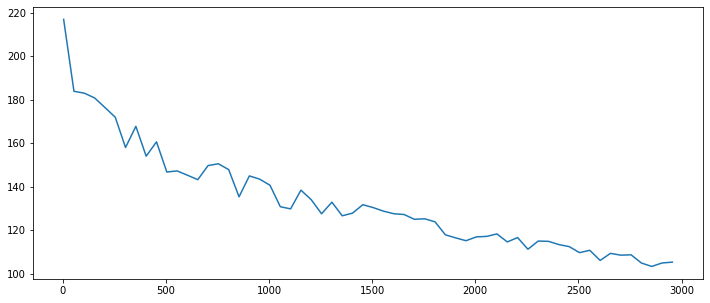

In [96]:
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 3000, 50)), scores)

В реальности метод локтя работает так себе (где на картинке локоть сказать сложно). И честным ответом на "как найти оптимальное количество кластеров" будет - а спросите что-нибудь попроще.

## Домашнее задание

1. На нескольких алгоритмах кластеризации, умеющих работать с sparse матрицами, проверьте, что работает лучше Count_Vectorizer или TfidfVectorizer (попробуйте выжать максимум из каждого - попробуйте нграммы, символьные нграммы, разные значения max_features и min_df) (3 балла)

2. На нескольких алгоритмах кластеризации проверьте, какое матричное разложение (TruncatedSVD или NMF) работает лучше для кластеризации. (3 балла)

3. С помощью алгоритмов, умеющих выделять выбросы, попробуйте найти необычные объявления (необычные - это такие, которые непонятно к какой категории можно вообще отнести, что-то с ошибками или вообще какая-то дичь). В этом задании можно использовать любую векторизацию. (4 балла)

Используйте те же данные, что и в семинаре (колонки - title и category_name)

Делайте соответствующие вашими ресурсам и потребностям алгоритма подвыборки из всего датасета. Для сравнения используйте любую из метрик, которые есть в семинаре. Оценивать на глаз тоже можно, но тогда нужно объяснить, почему вы считаете одну кластеризацию лучше. 

НЕ ЗАБЫВАЙТЕ подбирать параметры в кластеризации. **За использование всех параметров по умолчанию, оценка будет снижаться** (под использованием всех параметров по умолчанию я имею в виду что-то такое -  `cluster = DBSCAN()`) 

Если получится, используйте метод локтя. (1 бонусный балл)